# Tarefas de Manipulação

In [1]:
%autosave 2
%load_ext autoreload
%autoreload 2
%matplotlib inline

Autosaving every 2 seconds


In [2]:
import pandas as pd
import numpy as np

In [3]:
import os
import pathlib
import glob
import itertools
import shutil
import requests
import zipfile
from io import StringIO

In [4]:
import cv2
from PIL import Image, ImageShow

In [5]:
from skimage import exposure
from sklearn.preprocessing import normalize
from skimage.transform import rescale
from skimage.filters import try_all_threshold

In [6]:
from matplotlib import pyplot as plt

In [7]:
dataDir = 'data'

In [148]:
#!unzip Dataset\ Trainee\ Oficial\ Top.zip -d data/

In [8]:
def aplica_funcao(img:np.ndarray, funcao, paramns:dict=dict()):
    """
    aplicar alguma funcao em uma imagem
    
    @input
        img(np.ndarray) imagem de entrada
        funcao: funçao a ser aplicada na imagens
        paramns(dict): parametros a serem passados para funçao
        
    @output
        np.ndarray: imagem retornada da função
    """
    paramns['img'] = img
    img_tranf = funcao(**paramns)
    
    return img_tranf

In [111]:
def plot_comp(img_orig:np.ndarray, img_alt:np.ndarray, funcname:str):
    """
    plota uma matriz de imgs 1x2 com a imagem a original e alterada
    
    @input
        img_orig(np.ndarray) imagem original
        img_alt(np.ndarray) imagem alterada
        funcname(str) nome da funçao aplicada na img_orig para ser usada como label
    """
    fig, ax = plt.subplots(1, 2, figsize=(12,12))
    
    ax[0].imshow(img_orig)
    ax[0].set_title('Imagem original')
    ax[0].set_axis_off()
    
    ax[1].imshow(img_alt, cmap='gray')
    ax[1].set_title(f'Imagem modificada com {funcname}')
    ax[1].set_axis_off()

## Tarefa 1 - Visualização

In [9]:
def show_img(metodo:str, imgpath:str):
    """
    Recebe o path de uma imagem e plota essa imagem
    utilizando a bilbioteca escolhida no parametro path
    
    @input:
        - metodo(str): biblioteca a ser usada, valores aceitos 'cv2'(opencv), 'mpl'(matplotlib) e 'plw'(pillow)
        - imgpath(str): path da imagem
    
    @output
        - (matplotlib.image.AxesImage): imagem plotada
    """
    if metodo == 'mpl':
        img = plt.imread(imgpath)
        plt.imshow(img)
    
    elif metodo == 'plw':
        img = Image.open(imgpath)
        ImageShow.show(img)
        
    elif metodo == 'cv2':
        img = cv2.imread(imgpath)
        cv2.imshow('image',img)
        cv2.waitKey()
        cv2.destroyAllWindows()
        
    else:
        raise ValueError("o metodo deve ser alguns do valores %r"%['cv2', 'mpl', 'plw'])

In [10]:
img = plt.imread('data/src/DarthVader/02b6c14e9ddadd5522b12f0d2b421595a00ee410.jpg')

## Tarefa 2 - Espaços de cores

Para converter a imagem para preto e branco primeiro é preciso transforma-la em escala de cinza multiplicando os valores RGB por respectivas constantes, sendo que o opencv usa o espaço BGR, os vetores para multipliçao ficam:
$$Y = \left[\begin{array}{@{}c@{}}
    B \\
    G \\
    R 
    \end{array} \right] 
    \times 
    \left[\begin{array}{@{}c@{}}
    \frac{114}{1000} \\
    \frac{587}{1000} \\
    \frac{299}{1000}
    \end{array} \right]$$

Depois a partir de um threshold ($T$) definir pixel abaixo de valor como preto (0) a acima branco(255)
$$ 
    \begin{equation}
        P_i = \left \{\begin{array}{ll} 
                           255,\quad Y \geq T;\\
                           0,\quad Y < T
                       \end{array}
               \right.
    \end{equation}$$

In [44]:
def img2bw(img, how:bool=1):
    """
    Converter uma imagem para preto e branco usando numpy
    
    @input
        img (numpy.ndarray): Imagem a ser convertida
        how(bool): 0 para usar a implementaçáo do opencv/skimage e 
                   1 para usar a implementaçao manual
    @output
        (numpy.ndarray): Imagem de entrada em preto e branco
    """
    # Abaixo ou igual ao threshold substitui por 0
    # acima por 255
    threshold = int(np.ceil(255 / 2))   
    
    if how == 1:
        imshape = (img.shape[0], img.shape[1])
        img_bw = np.empty(imshape)

        xy = []

        for r in itertools.product(list(range(img.shape[0])), list(range(img.shape[1]))): 
            xy.append([r[0],r[1]])

        for idx in xy:
            Y = np.dot(img[idx[0], idx[1]], [.114, .587, .299])
            img_bw[idx[0], idx[1]] = [np.uint8(0) if Y <= threshold else np.uint8(255)][0]
    else:
        img_bw = cv2.threshold(cv2.cvtColor(img, 
                                            cv2.COLOR_BGR2GRAY), 
                               threshold, 
                               255, 
                               cv2.THRESH_BINARY )[1]
        
    return img_bw

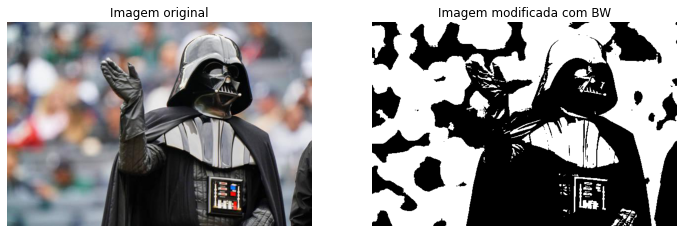

In [29]:
plot_comp(img, 
          aplica_funcao(img, 
                        img2bw), 
          'BW')

### Tarefa 3 - Augmentation

#### Flip

In [45]:
def imgFlip(img:np.ndarray, eixo:bool=0, how:bool=1):
    """
    Inverter a imagem em torno de um eixo (x, y)
    
    @input
        img (np.ndarray): imagem de entrada
        eixo (str): 1 para inverter na horizontal e 0 na vertical
        how(bool): 0 para usar a implementaçáo do opencv/skimage e 
                   1 para usar a implementaçao manual
    @output
        - np.ndarray: imagem invertida
    """
    img_out = np.empty(img.shape)
    
    if how == 1:
        if eixo == 0:
            for i, row in enumerate(img[::-1]):
                img_out[i] = row
        else:
            for i, col in enumerate(img[:, ::-1]):
                img_out[i] = col
                
        img_out = img_out.astype(np.uint8)
        
    else:
        img_out = cv2.flip(img, flipCode=eixo)
        
    return img_out

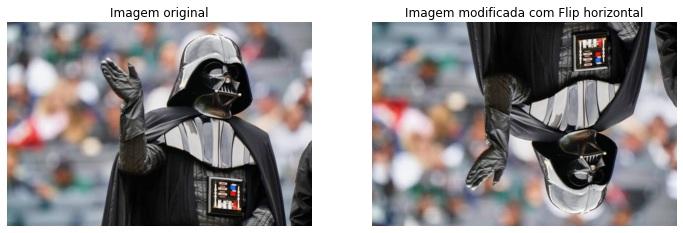

In [46]:
plot_comp(img, 
          aplica_funcao(img, 
                        imgFlip), 
          funcname='Flip horizontal')

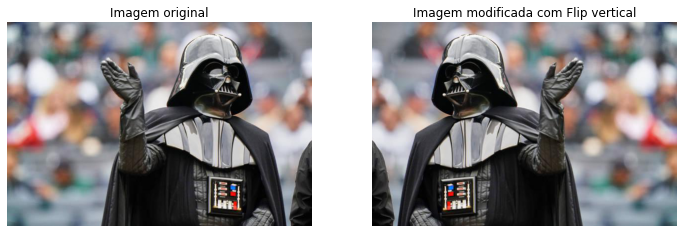

In [47]:
plot_comp(img, 
          aplica_funcao(img, 
                        imgFlip ,
                        paramns={'eixo':1}), 
          funcname='Flip vertical')

####  Rotação
$$W_{new} = W_{img}cos(\theta) + W_{img}sin(\theta)$$
$$H_{new} = H_{img}cos(\theta) + H_{img}sin(\theta)$$

In [48]:
def imgRotation(img, theta:int=None, how:bool=1):
    """
    Rotacionar uma imagem usando uma matriz de rotaçao, como cada pixel tem 
    uma coordenada xy a ideia e pegar cada um desses valores, rotaciona-los
    em um angulo theta a partir do eixo de origem da imagem definido no centro 
    inferior e rescreve-los em uma nova matriz com uma nova coordenada xy
    
    @input
        img (np.ndarray): imagem de entrada
        theta (int): angulo de rotacao, se nenhum valor for passado e
                     definido um angulo aleatório entre 0 e 360
        how(bool): 0 para usar a implementaçáo do opencv/skimage e 
                   1 para usar a implementaçao manual
    @output
        - np.ndarray: imagem rotacionada
    """
    if theta is None:
        theta = np.random.randint(1, 360)
    else: 
        pass
    
    if how == 1:
        theta = np.radians(theta)
        c, s = np.cos(theta), np.sin(theta)

        h_img, w_img, b = img.shape

        h_new  = round(abs( h_img * c ) + abs( h_img * s )) + 1
        w_new  = round(abs( w_img * c ) + abs( w_img * s )) + 1

        img_out = np.zeros((h_new,
                            w_new,
                            b))

        Oh = round((( h_new + 1 ) / 2 ) -1 )
        Ow = round((( w_new + 1 ) / 2 ) -1 )

        for i in range(h_img):
            for j in range(w_img):
                y = h_img - 1 - i - Oh                   
                x = w_img - 1 - j - Ow                      

                y_new = round(-x * s + y * c)
                x_new = round( x * c + y * s)

                y_new = Oh - y_new
                x_new = Ow - x_new

                if 0 <= x_new < w_new and 0 <= y_new < h_new and x_new >= 0 and y_new >= 0:
                    img_out[y_new, x_new, :] = img[i, j, :] 
                    
        img_out = img_out.astype(np.uint8)
                    
    elif how == 0:
        h, w = img.shape[0], img.shape[1]
    
        x = ( ( w / 2 ) + 1 ) -1
        y = ( ( h / 2 ) + 1 ) -1

        M = cv2.getRotationMatrix2D((x, y), theta, 1.0)
        img_out = cv2.warpAffine(img, M, (w, h))
    
    return img_out

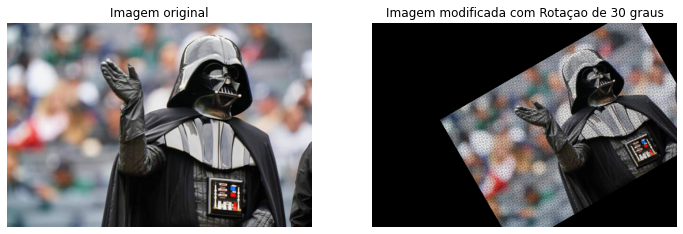

In [41]:
plot_comp(img, 
          aplica_funcao(img, imgRotation, paramns={'theta':30}),
          funcname='Rotaçao de 30 graus')

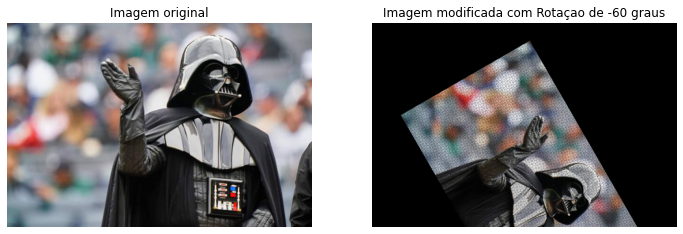

In [43]:
plot_comp(img, 
          aplica_funcao(img, imgRotation, paramns={'theta':-60}),
          funcname='Rotaçao de -60 graus')

#### Zoom

In [144]:
def imgZoom(img:np.ndarray):
    """
    recortar a imagem com delimitaçoes definidas aleatoriamente
    com slicee e, com a imagem recordada aplicar uma interpolçao para
    expandir a imagem

    @input
        - img (np.ndarray) 
    @output
        - np.ndarray
    """
    h, w, b = img.shape
    
    xi = np.random.randint(0, w)
    xf = np.random.randint(0, w)
    yi = np.random.randint(0, h)
    yf = np.random.randint(0, h)
    
    if xi + xf > w: 
        xf = w
        
    if yi + yf > h: 
        yf = h
        
    img_crop = img[yi:yi+yf, xi:xi+xf]

    return cv2.resize(img_crop, 
                      None, 
                      fx=5, fy=5, 
                      interpolation=cv2.INTER_LINEAR)

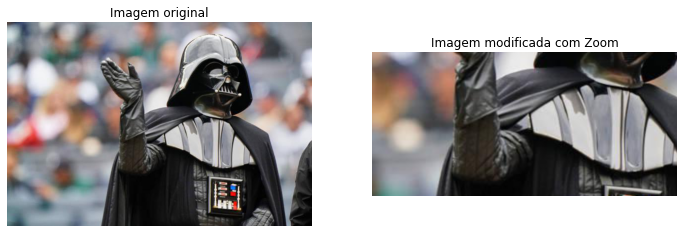

In [91]:
plot_comp(img, 
          aplica_funcao(img, imgZoom),
          funcname='Zoom')

#### Constraste e brilho
A partir da equçao: $s = cr^\gamma$ em que $\gamma$ e $r$ sao constantes positivas, sendo que para valores $\gamma < 1$  sao mapeados valores mais escuros da imagem para uma mais ampla, dando brilho a imagem, a para valores de $\gamma \geq 1$ acontece o oposto, e a intensidade desses desses valores é definido por uma constante r

In [113]:
def imgLinearTransf(img, r, gamma):
    """
    Aplicar uma transformaçao linear na imagem
    para ajuste do brilho e contraste
    
    @input
        img (np.ndarray): imagem de entrada
        r: componente de ajuste do contraste
        gamma: componente de ajuste do brilho
        
    @output
        - np.ndarray: 
    """
    lut_matrix = 255 * r * (np.linspace(0, 1, 256) ** gamma)
    lut_matrix = np.minimum(lut_matrix, 255).astype('uint8')
    img_out = lut_matrix[img]
        
    return img_out

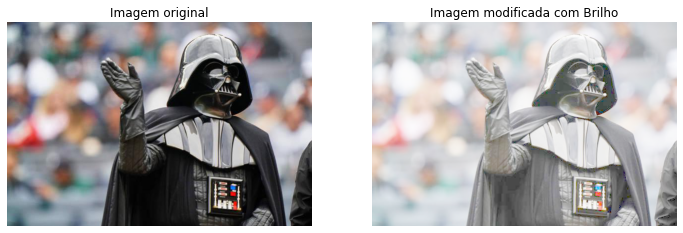

In [121]:
plot_comp(img, 
          aplica_funcao(img, imgLinearTransf, paramns={'r':1, 'gamma':.3}),
          funcname='Brilho')

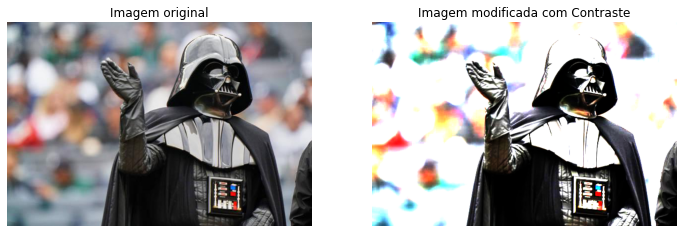

In [125]:
plot_comp(img, 
          aplica_funcao(img, imgLinearTransf, paramns={'r':5, 'gamma':2}),
          funcname='Contraste')

### Tarefa 4 - Filtros

In [136]:
def imgBlur(img):
    """
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(img,-1,kernel)
    
    return dst

In [139]:
def imgGBlur(img):
    """
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    return cv2.GaussianBlur(img,(5,5),0)

In [140]:
def imgMBlur(img):
    """
    @input
        - img (np.ndarray): 
    @output
        - np.ndarray: 
    """
    return cv2.medianBlur(img,5)

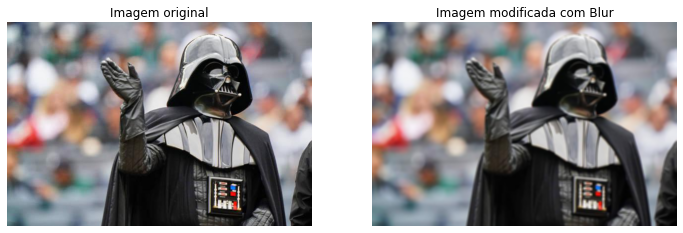

In [141]:
plot_comp(img, aplica_funcao(img, imgBlur), funcname='Blur')

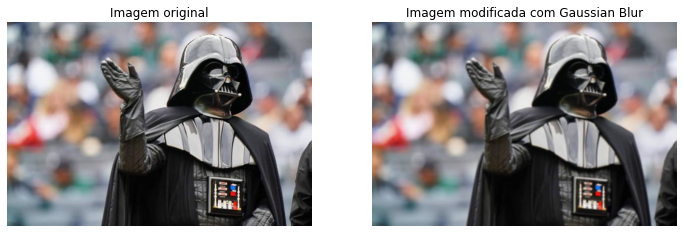

In [142]:
plot_comp(img, aplica_funcao(img, imgGBlur), funcname='Gaussian Blur')

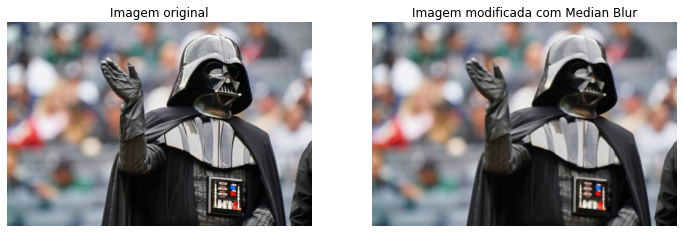

In [143]:
plot_comp(img, aplica_funcao(img, imgMBlur), funcname='Median Blur')